## Explore Overfitting and Underfitting

We'll explore two common regularization techniques—weight regularization and dropout—and

In [62]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout

In [44]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load  dataset

dataset = pd.read_csv('input_data.csv', sep='\t', encoding='utf-8' ,index_col=0)


X_data = dataset.drop(columns=['Events'])

#one-hot encode target column
Y_data = to_categorical(dataset.Events)


#get number of columns in training data
n_cols = train_X.shape[1]


In [45]:
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.33, random_state=seed)

# Baseline Model

In [46]:
baseline_model = Sequential()

#add layers to model
baseline_model.add(Dense(16, activation='relu', input_shape=(n_cols,)))
baseline_model.add(Dense(16, activation='relu'))
baseline_model.add(Dense(2, activation='sigmoid'))

baseline_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 16)                112       
_________________________________________________________________
dense_51 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_52 (Dense)             (None, 2)                 34        
Total params: 418
Trainable params: 418
Non-trainable params: 0
_________________________________________________________________


In [47]:

#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=5)

# Fit the model

baseline_history = baseline_model.fit(X_train,y_train, 
                      epochs=20, 
                      validation_split=0.3,
                      batch_size=64,
                      callbacks=[early_stopping_monitor],
                      verbose=2)

Train on 106799 samples, validate on 45771 samples
Epoch 1/20
 - 5s - loss: 0.2096 - acc: 0.9558 - binary_crossentropy: 0.3230 - val_loss: 0.1676 - val_acc: 0.9585 - val_binary_crossentropy: 0.2928
Epoch 2/20
 - 3s - loss: 0.1766 - acc: 0.9558 - binary_crossentropy: 0.3087 - val_loss: 0.1632 - val_acc: 0.9585 - val_binary_crossentropy: 0.2781
Epoch 3/20
 - 3s - loss: 0.1735 - acc: 0.9558 - binary_crossentropy: 0.2995 - val_loss: 0.1641 - val_acc: 0.9585 - val_binary_crossentropy: 0.2864
Epoch 4/20
 - 3s - loss: 0.1723 - acc: 0.9559 - binary_crossentropy: 0.3104 - val_loss: 0.1609 - val_acc: 0.9584 - val_binary_crossentropy: 0.2906
Epoch 5/20
 - 3s - loss: 0.1708 - acc: 0.9559 - binary_crossentropy: 0.3072 - val_loss: 0.1601 - val_acc: 0.9586 - val_binary_crossentropy: 0.2842
Epoch 6/20
 - 3s - loss: 0.1702 - acc: 0.9559 - binary_crossentropy: 0.2993 - val_loss: 0.1608 - val_acc: 0.9585 - val_binary_crossentropy: 0.2770
Epoch 7/20
 - 3s - loss: 0.1695 - acc: 0.9558 - binary_crossentropy

In [48]:
smaller_model = Sequential()

#add layers to model
smaller_model.add(Dense(4, activation='relu', input_shape=(n_cols,)))
smaller_model.add(Dense(4, activation='relu'))
smaller_model.add(Dense(2, activation='sigmoid'))

smaller_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

smaller_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 10        
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Fit the model

smaller_history = smaller_model.fit(X_train,y_train, 
                      epochs=20, 
                      validation_split=0.3,
                      batch_size=64,
                      callbacks=[early_stopping_monitor],
                      verbose=2)

Train on 106799 samples, validate on 45771 samples
Epoch 1/20
 - 4s - loss: 0.3217 - acc: 0.8161 - binary_crossentropy: 1.1508 - val_loss: 0.1676 - val_acc: 0.9585 - val_binary_crossentropy: 0.2379
Epoch 2/20
 - 3s - loss: 0.1772 - acc: 0.9558 - binary_crossentropy: 0.2539 - val_loss: 0.1664 - val_acc: 0.9585 - val_binary_crossentropy: 0.2418
Epoch 3/20
 - 3s - loss: 0.1759 - acc: 0.9558 - binary_crossentropy: 0.2578 - val_loss: 0.1654 - val_acc: 0.9585 - val_binary_crossentropy: 0.2443
Epoch 4/20
 - 3s - loss: 0.1755 - acc: 0.9558 - binary_crossentropy: 0.2619 - val_loss: 0.1687 - val_acc: 0.9585 - val_binary_crossentropy: 0.2493
Epoch 5/20
 - 3s - loss: 0.1751 - acc: 0.9558 - binary_crossentropy: 0.2667 - val_loss: 0.1669 - val_acc: 0.9585 - val_binary_crossentropy: 0.2518
Epoch 6/20
 - 3s - loss: 0.1749 - acc: 0.9558 - binary_crossentropy: 0.2646 - val_loss: 0.1641 - val_acc: 0.9585 - val_binary_crossentropy: 0.2514
Epoch 7/20
 - 3s - loss: 0.1747 - acc: 0.9558 - binary_crossentropy

In [50]:

bigger_model = Sequential()

#add layers to model
bigger_model.add(Dense(512, activation='relu', input_shape=(n_cols,)))
bigger_model.add(Dense(512,activation='relu'))
bigger_model.add(Dense(2, activation='sigmoid'))

bigger_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

bigger_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 512)               3584      
_________________________________________________________________
dense_57 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_58 (Dense)             (None, 2)                 1026      
Total params: 267,266
Trainable params: 267,266
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Fit the model

bigger_history = bigger_model.fit(X_train,y_train, 
                      epochs=20, 
                      validation_split=0.3,
                      batch_size=64,
                      callbacks=[early_stopping_monitor],
                      verbose=2)

Train on 106799 samples, validate on 45771 samples
Epoch 1/20
 - 10s - loss: 0.2533 - acc: 0.9549 - binary_crossentropy: 0.8340 - val_loss: 0.1655 - val_acc: 0.9585 - val_binary_crossentropy: 0.3193
Epoch 2/20
 - 9s - loss: 0.1751 - acc: 0.9558 - binary_crossentropy: 0.3309 - val_loss: 0.1678 - val_acc: 0.9585 - val_binary_crossentropy: 0.3001
Epoch 3/20
 - 9s - loss: 0.1717 - acc: 0.9558 - binary_crossentropy: 0.3145 - val_loss: 0.1626 - val_acc: 0.9585 - val_binary_crossentropy: 0.2977
Epoch 4/20
 - 8s - loss: 0.1707 - acc: 0.9558 - binary_crossentropy: 0.3256 - val_loss: 0.1620 - val_acc: 0.9585 - val_binary_crossentropy: 0.3050
Epoch 5/20
 - 8s - loss: 0.1697 - acc: 0.9558 - binary_crossentropy: 0.3368 - val_loss: 0.1600 - val_acc: 0.9585 - val_binary_crossentropy: 0.3310
Epoch 6/20
 - 8s - loss: 0.1689 - acc: 0.9558 - binary_crossentropy: 0.3553 - val_loss: 0.1593 - val_acc: 0.9585 - val_binary_crossentropy: 0.3579
Epoch 7/20
 - 8s - loss: 0.1683 - acc: 0.9558 - binary_crossentrop

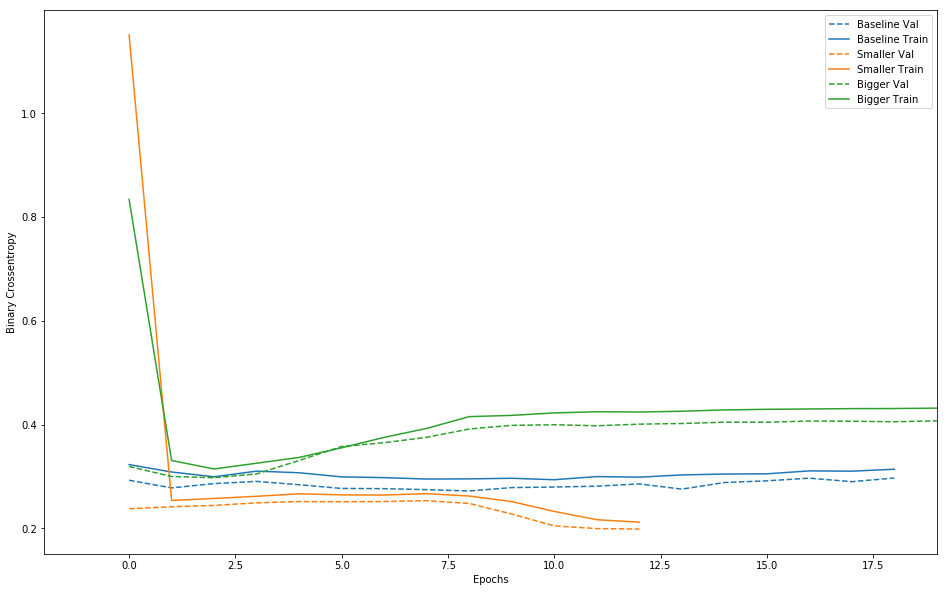

In [53]:
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([-2,max(history.epoch)])


plot_history([('baseline', baseline_history),
              ('smaller', smaller_history),
              ('bigger', bigger_history)])

# Regularization

## *L2*

In [55]:
l2_model = Sequential()

#add layers to model
l2_model.add(Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001),input_shape=(n_cols,)))
l2_model.add(Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
l2_model.add(Dense(2, activation='sigmoid'))

l2_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

l2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 512)               3584      
_________________________________________________________________
dense_60 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_61 (Dense)             (None, 2)                 1026      
Total params: 267,266
Trainable params: 267,266
Non-trainable params: 0
_________________________________________________________________


In [56]:

# Fit the model

l2_model_history =  l2_model.fit(X_train,y_train, 
                      epochs=20, 
                      validation_split=0.3,
                      batch_size=64,
                      callbacks=[early_stopping_monitor],
                      verbose=2)

Train on 106799 samples, validate on 45771 samples
Epoch 1/20
 - 9s - loss: 0.3488 - acc: 0.9553 - binary_crossentropy: 0.4992 - val_loss: 0.1980 - val_acc: 0.9585 - val_binary_crossentropy: 0.2723
Epoch 2/20
 - 8s - loss: 0.1885 - acc: 0.9558 - binary_crossentropy: 0.2539 - val_loss: 0.1675 - val_acc: 0.9585 - val_binary_crossentropy: 0.2190
Epoch 3/20
 - 8s - loss: 0.1751 - acc: 0.9558 - binary_crossentropy: 0.2426 - val_loss: 0.1637 - val_acc: 0.9585 - val_binary_crossentropy: 0.2367
Epoch 4/20
 - 8s - loss: 0.1731 - acc: 0.9558 - binary_crossentropy: 0.2542 - val_loss: 0.1658 - val_acc: 0.9585 - val_binary_crossentropy: 0.2436
Epoch 5/20
 - 8s - loss: 0.1722 - acc: 0.9558 - binary_crossentropy: 0.2734 - val_loss: 0.1638 - val_acc: 0.9585 - val_binary_crossentropy: 0.2667
Epoch 6/20
 - 8s - loss: 0.1717 - acc: 0.9558 - binary_crossentropy: 0.2831 - val_loss: 0.1631 - val_acc: 0.9585 - val_binary_crossentropy: 0.2619
Epoch 7/20
 - 9s - loss: 0.1712 - acc: 0.9558 - binary_crossentropy

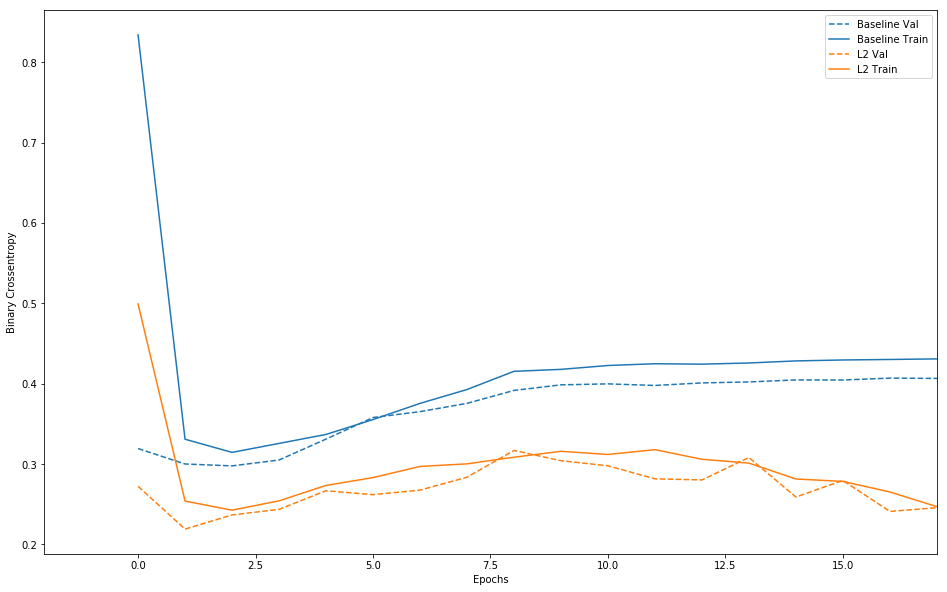

In [57]:
plot_history([('baseline', bigger_history),
              ('l2', l2_model_history)])

## *Dropout*

In [63]:
dpt_model = Sequential()

#add layers to model
dpt_model.add(Dense(512, activation='relu',input_shape=(n_cols,)))
dpt_model.add(Dropout(0.5))
dpt_model.add(Dense(512,activation='relu'))
dpt_model.add(Dropout(0.5))
dpt_model.add(Dense(2, activation='sigmoid'))

dpt_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy', 'binary_crossentropy'])

dpt_model.summary()


# Fit the model

dpt_model_history =  dpt_model.fit(X_train,y_train, 
                      epochs=20, 
                      validation_split=0.3,
                      batch_size=64,
                      callbacks=[early_stopping_monitor],
                      verbose=2)

W0808 15:53:20.182235 139996826326848 deprecation.py:506] From /home/francovm/anaconda3/envs/keras/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 512)               3584      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 2)                 1026      
Total params: 267,266
Trainable params: 267,266
Non-trainable params: 0
_________________________________________________________________
Train on 106799 samples, validate on 45771 samples
Epoch 1/20
 - 11s - loss: 0.2568 - acc: 0.9554 - binary_crossentropy: 0.5364 - val_lo

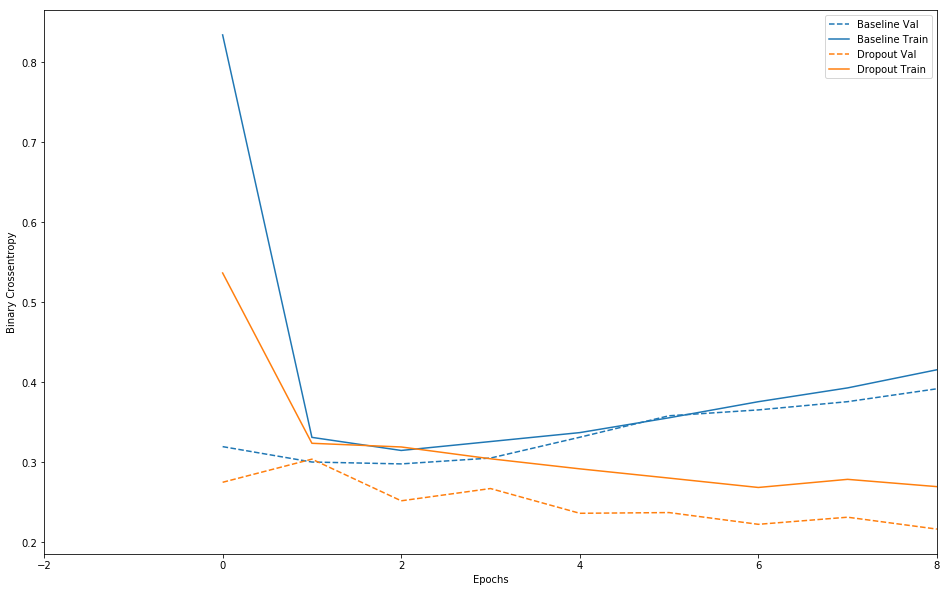

In [64]:
plot_history([('baseline', bigger_history),
              ('dropout', dpt_model_history)])

In [65]:
# evaluate the model
scores = bigger_model.evaluate(X_test,y_test)
print((scores[1]*100))

75147/75147 [==============================] - 3s 40us/step
95.52344072324647


# USE THIS FUNCTION TO FIND BATCH SIZE, JUST EXACTLY BEFORE STARTING YOUR TRAINING/ TESTING.

In [37]:
def FindBatchSize(model):
    """#model: model architecture, that is yet to be trained"""
    import os, sys, psutil, gc, tensorflow, keras
    import numpy as np
    from keras import backend as K
    BatchFound= 16

    try:
        total_params= int(model.count_params());    GCPU= "CPU"
        #find whether gpu is available
        try:
            if K.tensorflow_backend._get_available_gpus()== []:
                GCPU= "CPU";    #CPU and Cuda9GPU
            else:
                GCPU= "GPU"
        except:
            from tensorflow.python.client import device_lib;    #Cuda8GPU
            def get_available_gpus():
                local_device_protos= device_lib.list_local_devices()
                return [x.name for x in local_device_protos if x.device_type == 'GPU']
            if "gpu" not in str(get_available_gpus()).lower():
                GCPU= "CPU"
            else:
                GCPU= "GPU"

        #decide batch size on the basis of GPU availability and model complexity
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <1000000):
            BatchFound= 64    
        if (os.cpu_count() <16) and (total_params <500000):
            BatchFound= 64  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params <2000000) and (total_params >=1000000):
            BatchFound= 32      
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=2000000) and (total_params <10000000):
            BatchFound= 16  
        if (GCPU== "GPU") and (os.cpu_count() >15) and (total_params >=10000000):
            BatchFound= 8       
        if (os.cpu_count() <16) and (total_params >5000000):
            BatchFound= 8    
        if total_params >100000000:
            BatchFound= 1

    except:
        pass
    try:

        #find percentage of memory used
        memoryused= psutil.virtual_memory()
        memoryused= float(str(memoryused).replace(" ", "").split("percent=")[1].split(",")[0])
        if memoryused >75.0:
            BatchFound= 8
        if memoryused >85.0:
            BatchFound= 4
        if memoryused >90.0:
            BatchFound= 2
        if total_params >100000000:
            BatchFound= 1
        print("Batch Size:  "+ str(BatchFound));    gc.collect()
    except:
        pass

    memoryused= [];    total_params= [];    GCPU= "";
    del memoryused, total_params, GCPU;    gc.collect()
    return BatchFound



#####################################################################################################
#####################################################################################################

In [40]:
FindBatchSize(baseline_model)

Batch Size:  64


64